In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lvm_to_h5 import *
from data_utils import import_lvm_file, plot_data

## Importing Data

## Define Data Folders

In [2]:
# User Selection

Dropbox_drive = "F:/"
station_selected = "Station 3/"
NI_test_name = "st_1_test___002"


# Derived data paths
parent_data_folder = Dropbox_drive + "Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
NI_raw_data_folder = parent_data_folder + "/NI/Raw Data/"

NI_converted_data_folder = parent_data_folder + "/NI/Converted Data/"

full_raw_path = NI_raw_data_folder + station_selected + NI_test_name + ".lvm"
full_converted_path = NI_converted_data_folder + station_selected + NI_test_name + ".h5"

# Full raw path (hardcoded)
full_raw_path = "F:/Dropbox/Projects/Field Test Data/CNRL - Test/Station 1/NI/st_1_test___001.lvm"

### Directly importing from .lvm

In [3]:
# Useful, but takes a long time to load each file.
# 1.9GB file: 4m 20s. Optimized: 
# 380MB file: 0m 41s. Optimized: 7.8 s
data_frame = import_lvm_file(full_raw_path)

## Header

In [13]:
data_frame = data_frame.rename(columns={"X_Value": "time"})

In [14]:
print(data_frame.head())

       time  D1 - Channel 0  D1 - Channel 1  D1 - Channel 2  D2 - Channel 0   
0  0.000000        0.021517       -0.036425        0.005949       -0.040674  \
1  0.000098        0.018330       -0.025690        0.012005       -0.042268   
2  0.000195        0.016736       -0.021585        0.029217       -0.042268   
3  0.000293        0.012593       -0.026637        0.019336       -0.043544   
4  0.000391        0.010044       -0.032320        0.004992       -0.043544   

   D2 - Channel 1  D2 - Channel 2  D1 - Channel 3  D2 - Channel 3   
0       -0.066245        0.144794       -0.001620       -0.319718  \
1       -0.045393        0.122161       -0.001304       -0.010023   
2       -0.040654        0.099528       -0.001620        0.280711   
3       -0.059610        0.110048       -0.000988        0.474112   
4       -0.084570        0.145113       -0.001304        0.464316   

   D3 - Channel 0  D3 - Channel 1  D3 - Channel 2  D4 - Channel 0   
0       -0.050639       -0.047139        

## Meta Validation

### Data Points & Recording Time

In [5]:
# Access the first column using its index and count the number of data points
time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 820000
Data was recorded for 81.05 seconds
Data was recorded for 1.35 minutes
Data was recorded for 0.02 hours


### Sampling rate, Consistency and CV

In [6]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10000  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")


Expected sampling rate: 10000 Hz
Effective sampling rate: 10116.63 Hz
Number of time intervals exceeding 5.0% deviation: 1
Percentage of time intervals exceeding 5.0% deviation: 0.00%


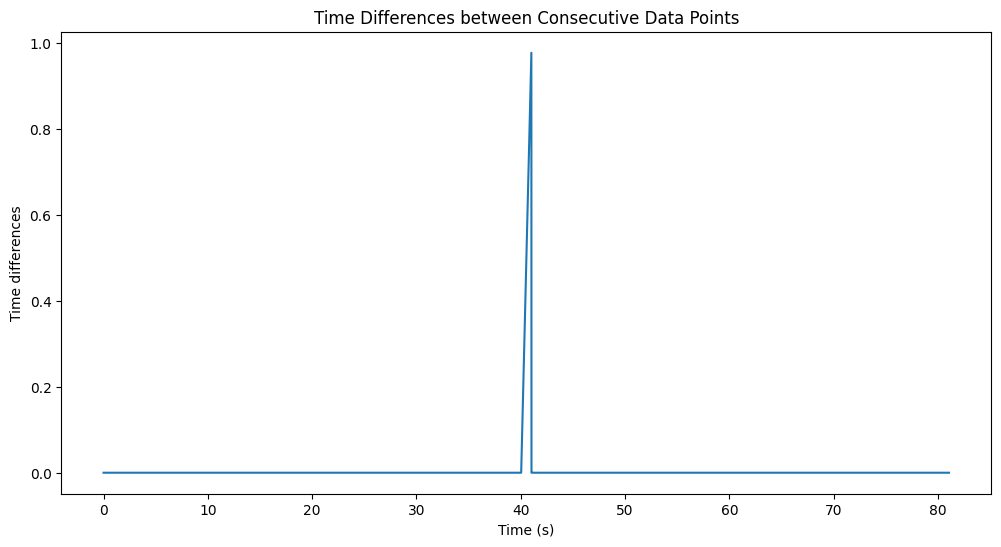

In [7]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

### Disk Space Required

In [8]:
# Calculate the duration in seconds
start_time = data_frame.iloc[0, 0]
end_time = data_frame.iloc[-1, 0]
duration_seconds = end_time - start_time

# Get the file size in bytes
file_size_bytes = os.path.getsize(full_raw_path)

# Convert file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# Calculate disk space per second in megabytes
disk_space_per_second_mb = file_size_mb / duration_seconds

print(f"Disk space per second: {round(disk_space_per_second_mb,2)} MB/s")

print(f"Disk space per minute: {round(disk_space_per_second_mb*60,2)} MB/min")

print(f"Disk space per hour: {round(disk_space_per_second_mb*60*60/1024,2)} GB/hour")

Disk space per second: 1.39 MB/s
Disk space per minute: 83.61 MB/min
Disk space per hour: 4.9 GB/hour


In [29]:
# Apply the condition to all channels except for the first one (time_values)
# If a value is greater than 5 or less than -5, set it to zero
#data_frame.iloc[:, 1:] = data_frame.iloc[:, 1:].applymap(lambda x: 0 if x > 5 or x < -5 else x)

## Signal

### Accelerometer 1 (D1 - 0, 1, 2)

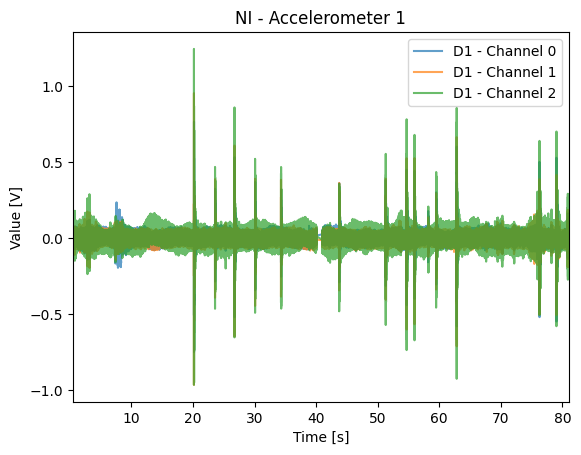

In [20]:
plot_data(data_frame, ["D1 - Channel 0","D1 - Channel 1","D1 - Channel 2"], start_time=0.5, end_time=None, transparency=0.7, title = "NI - Accelerometer 1")

### Accelerometer 2 (D2 - 0, 1, 2)

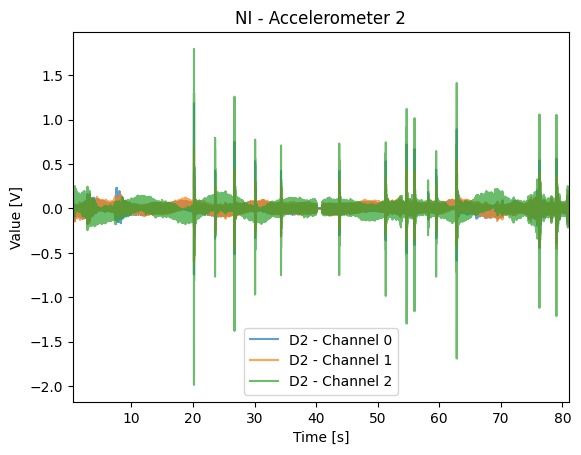

In [16]:
plot_data(data_frame, ["D2 - Channel 0","D2 - Channel 1","D2 - Channel 2"], start_time=0.5, end_time=None, transparency=0.7, title = "NI - Accelerometer 2")

### Accelerometer 3 (D3 - 0, 1, 2)

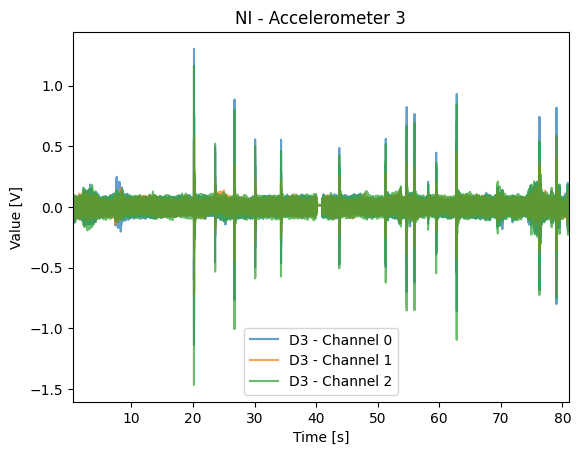

In [17]:
plot_data(data_frame, ["D3 - Channel 0","D3 - Channel 1","D3 - Channel 2"], start_time=0.5, end_time=None, transparency=0.7, title = "NI - Accelerometer 3")

### Accelerometer 4 (D4 - 0, 1, 2)

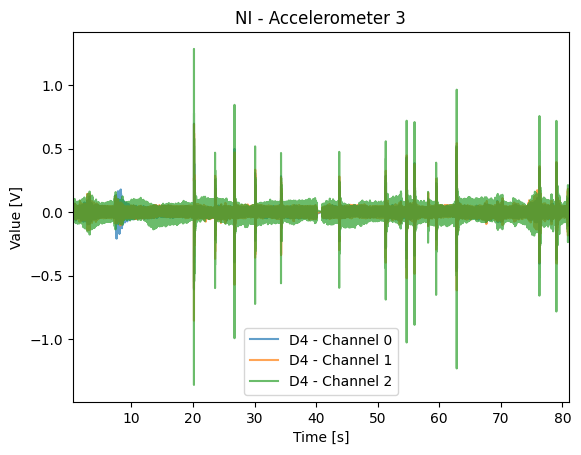

In [18]:
plot_data(data_frame, ["D4 - Channel 0","D4 - Channel 1","D4 - Channel 2"], start_time=0.5, end_time=None, transparency=0.7, title = "NI - Accelerometer 3")

### IRIG-B (D1-3 and D2-3)

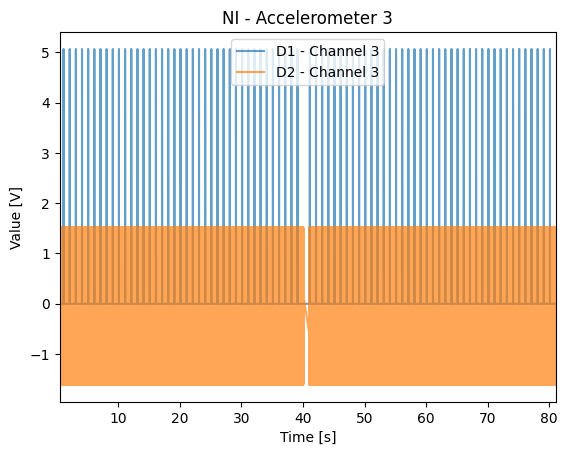

In [19]:
plot_data(data_frame, ["D1 - Channel 3","D2 - Channel 3"], start_time=0.5, end_time=None, transparency=0.7, title = "NI - Accelerometer 3")

### Device 2

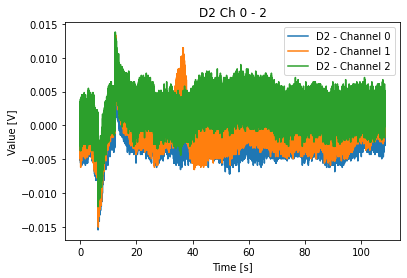

In [55]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D2 - Channel 0", "D2 - Channel 1", "D2 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((-10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D2 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


### IRIG-B

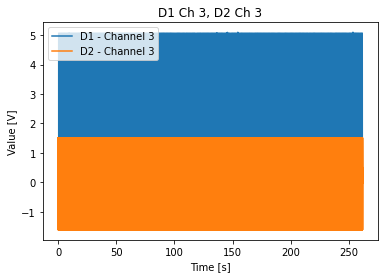

In [4]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D1 - Channel 3", "D2 - Channel 3"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((10, 11))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D1 Ch 3, D2 Ch 3')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 3

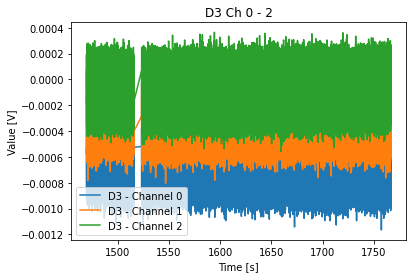

In [15]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D3 - Channel 0", "D3 - Channel 1", "D3 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((35, 40))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D3 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


## Device 4

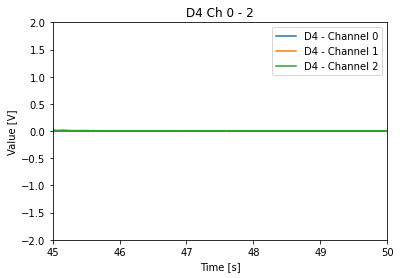

In [5]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["D4 - Channel 0", "D4 - Channel 1", "D4 - Channel 2"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

plt.xlim((45, 50))
plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()